In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn import tree

In [2]:
# import the dataset
df=pd.read_csv("storedata (2).csv")
df_cleaned=df.copy()
# df_cleaned.head(137)

In [3]:
# Step 1: Splitting the data into training and testing sets
X = df_cleaned.iloc[:, :-1]
y = df_cleaned.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
# check for missing values
df_cleaned.isnull().sum()

Town                  0
Country               0
Store ID              0
Manager name          0
Staff                 0
Floor Space           0
Window                0
Car park              0
Demographic score     0
Location              0
40min population      0
30 min population     0
20 min population     0
10 min population     0
Store age             0
Clearance space       0
Competition number    0
Competition score     0
Performance           0
dtype: int64

<AxesSubplot:xlabel='Performance', ylabel='count'>

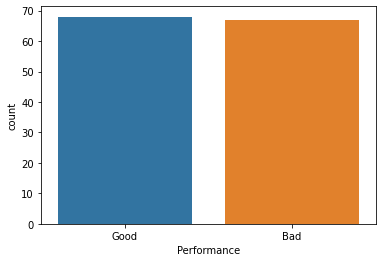

In [5]:
# check if target variable is ordinal or binary
sns.countplot(x='Performance',data=df_cleaned)

In [6]:
# check if the size of the oberservation set is sufficient
# df_cleaned.info()
featureValues={}
for d in df_cleaned.columns.tolist():
    count=df_cleaned[d].nunique()
    if count==1:
        featureValues[d]=count
# List of columns having same 1 unique value        
cols_to_drop= list(featureValues.keys())
print("Columns having 1 unique value are :n",cols_to_drop)


Columns having 1 unique value are :n []


In [7]:
# dropping columns
X_train = X_train.drop(['Manager name','Town','Country','Store ID'], axis=1)

# print(X_train.shape)
X_test = X_test.drop(['Manager name','Town','Country','Store ID'], axis=1)
# pr/int(X_test.shape)

In [8]:
# remove missing values
# X_train['Car park'].value_counts().plot(kind='bar')
X_train['Car park'] = X_train['Car park'].replace({'Y':'Yes','N':'No'})
X_test['Car park'] = X_test['Car park'].replace({'Y':'Yes','N':'No'})
# X_train['Car park'].value_counts().plot(kind='bar')
X_train['Car park']=X_train['Car park'].map({"Yes":1,"No":0})
X_test['Car park']=X_test['Car park'].map({"Yes":1,"No":0})



In [9]:
# Step 2: Data preprocessing
cat_cols = ['Car park','Location']
enc = OneHotEncoder(drop ='first').fit(X_train[cat_cols])   
cat_data_train = pd.DataFrame(enc.transform(X_train[cat_cols]).toarray(), columns=enc.get_feature_names_out(cat_cols))
cat_data_test = pd.DataFrame(enc.transform(X_test[cat_cols]).toarray(), columns=enc.get_feature_names_out(cat_cols))

In [10]:
# Scaling numerical features
num_cols = ['Demographic score',
            '20 min population',
            '10 min population',
            '30 min population',
            '40min population', 
            'Window',
            'Staff',
            'Floor Space', 
            'Store age', 
            'Clearance space', 
            'Competition number', 
            'Competition score',]
# scaler = StandardScaler().fit(X_train[num_cols])
mm_scaler = MinMaxScaler().fit(X_train[num_cols])
num_data_train = pd.DataFrame(mm_scaler.transform(X_train[num_cols]), columns=num_cols) #scaling training data
num_data_test = pd.DataFrame(mm_scaler.transform(X_test[num_cols]), columns=num_cols) #scaling training data

# Concatenate encoded categorical and scaled numerical data
X_train = pd.concat([num_data_train, cat_data_train], axis=1)  #for training set
X_test = pd.concat([num_data_test, cat_data_test], axis=1)     #for test data
print(X_train.describe(include="all"))

       Demographic score  20 min population  10 min population  \
count          94.000000          94.000000          94.000000   
mean            0.498818           0.176653           0.181422   
std             0.318359           0.203452           0.229729   
min             0.000000           0.000000           0.000000   
25%             0.222222           0.020022           0.019059   
50%             0.555556           0.102523           0.097262   
75%             0.777778           0.256449           0.236258   
max             1.000000           1.000000           1.000000   

       30 min population  40min population     Window      Staff  Floor Space  \
count          94.000000         94.000000  94.000000  94.000000    94.000000   
mean            0.292498          0.451042   0.526152   0.030254     0.530099   
std             0.249348          0.286803   0.278872   0.112926     0.273594   
min             0.000000          0.000000   0.000000   0.000000     0.000000   


In [20]:
# Define the hyperparameters to search over
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

# Define the logistic regression model
logreg = LogisticRegression(max_iter=1000)

# Perform grid search using 5-fold cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and use them to train the final model
best_params = grid_search.best_params_
final_logreg = LogisticRegression(**best_params, max_iter=1000)
final_logreg.fit(X_train, y_train)

# Evaluate the final model on the test data
y_pred = final_logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the logistic regression model: {accuracy:.2f}")

# Create a table of hyperparameters and accuracy
results = pd.DataFrame(grid_search.cv_results_)
results = results[['params', 'mean_test_score']]
results = results.sort_values(by='mean_test_score', ascending=False)
results = results.reset_index(drop=True)
results['params'] = results['params'].astype(str)
results[['C', 'penalty']] = results.params.str.extract("{'C': ([\d\.]+), 'penalty': '(\w+)'}")
results = results.drop(columns=['params'])
results = results.rename(columns={'mean_test_score': 'accuracy'})
# print(results)

Accuracy of the logistic regression model: 0.59


c:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueErr

In [12]:
# GRID CV SEARCH
param_grid = {'C':([0.1, 1, 10,100]), 'penalty': ['l2']}
estimator = LogisticRegression()
# estimator = LogisticRegression(solver='liblinear', penalty='l1')
grid = GridSearchCV(estimator, param_grid, cv=5)
grid.fit(X_train, y_train)
print(grid.best_params_)
best_estimator = grid.best_estimator_
best_estimator.fit(X_train, y_train)
score = best_estimator.score(X_test, y_test)
print(score)

{'C': 1, 'penalty': 'l2'}
0.5853658536585366


In [13]:
best_params = grid.best_params_
final_logreg = LogisticRegression(**best_params)
final_logreg.fit(X_train, y_train)
test_score = final_logreg.score(X_test, y_test)
print("Test accuracy:", test_score)

Test accuracy: 0.5853658536585366


Score of the best estimator: 0.5853658536585366
Accuracy of the logistic regression model: 0.61


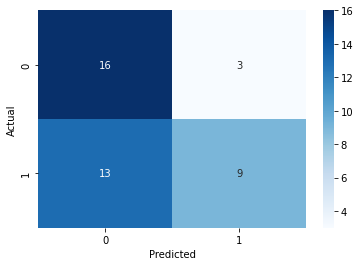

              precision    recall  f1-score   support

         Bad       0.55      0.84      0.67        19
        Good       0.75      0.41      0.53        22

    accuracy                           0.61        41
   macro avg       0.65      0.63      0.60        41
weighted avg       0.66      0.61      0.59        41



In [14]:
# Define the hyperparameters to search over
param_grid = {'C': [0.1], 'penalty': [ 'l2']}

# Define the logistic regression model
logreg = LogisticRegression(max_iter=1000)

# Perform grid search using 5-fold cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and use them to train the final model
best_params = grid_search.best_params_
final_logreg = LogisticRegression(**best_params, max_iter=1000)
final_logreg.fit(X_train, y_train)
score = best_estimator.score(X_test, y_test)
print(f"Score of the best estimator: {score}")
# Evaluate the final model on the test data
y_pred = final_logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the logistic regression model: {accuracy:.2f}")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred))

Accuracy: 0.59


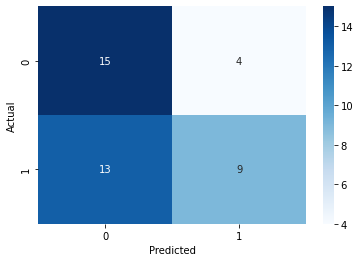

              precision    recall  f1-score   support

         Bad       0.54      0.79      0.64        19
        Good       0.69      0.41      0.51        22

    accuracy                           0.59        41
   macro avg       0.61      0.60      0.58        41
weighted avg       0.62      0.59      0.57        41



In [15]:
# Step 3: Model training and evaluation
logreg = LogisticRegression(penalty='l2', C=1.0, max_iter=1000)
# best_params = {'C': 1, 'penalty': 'l2'}
# logreg=LogisticRegression(**best_params)
# logreg=LogisticRegression(solver='liblinear', penalty='l2')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print(classification_report(y_test, y_pred))

In [16]:
print("Test Accuracy =",logreg.score(X_test, y_test))

Test Accuracy = 0.5853658536585366


In [17]:
y_pred = logreg.predict(X_test)
print(y_pred)
confusion_matrix(y_test, y_pred)

['Good' 'Bad' 'Bad' 'Bad' 'Good' 'Bad' 'Good' 'Bad' 'Bad' 'Bad' 'Bad'
 'Bad' 'Good' 'Bad' 'Bad' 'Good' 'Bad' 'Bad' 'Good' 'Good' 'Bad' 'Bad'
 'Bad' 'Bad' 'Bad' 'Bad' 'Bad' 'Bad' 'Good' 'Bad' 'Good' 'Bad' 'Bad'
 'Good' 'Bad' 'Bad' 'Good' 'Bad' 'Good' 'Bad' 'Good']


array([[15,  4],
       [13,  9]], dtype=int64)

In [18]:
Y = logreg.predict_proba(X_test)[:,1]
print(Y)

[0.87730548 0.30841594 0.23883968 0.40151457 0.72274979 0.32012027
 0.85670068 0.35996464 0.44455198 0.28653068 0.28900296 0.10237457
 0.8996196  0.31324316 0.22719638 0.63201751 0.43034363 0.14678962
 0.5266744  0.58263522 0.46797376 0.45743525 0.24732129 0.36461954
 0.41192305 0.26740252 0.349728   0.06013365 0.87234914 0.39274696
 0.58571369 0.18325333 0.22861282 0.79449441 0.38958995 0.11041583
 0.86246061 0.27203288 0.70500764 0.17537957 0.51930721]


In [19]:
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=1.0)
lasso_reg.fit(X_train, y_train)

ValueError: could not convert string to float: 'Good'

In [21]:
cross_val_score(lasso_reg, X_train, y_train, cv=5)
cross_val_score(ridge_reg, X_train, y_train, cv=5)


NameError: name 'lasso_reg' is not defined

In [ ]:
for alpha in [1, 10, 500, 1000]:
    lasso_reg = Lasso(alpha=alpha)
    lasso_reg.fit(X_train, y_train)
    print("Alpha = ", alpha, "CV Scores = ",cross_val_score(lasso_reg, X_train, y_train, cv=5))

In [ ]:

# Perform 5-fold cross-validation on the training data
scores = cross_val_score(logreg, X_train, y_train, cv=5)

# Print the average score and standard deviation across all 5 folds
print("Cross-validation scores:", scores)
print("Mean accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
# DECISION TREE
tree_clf = tree.DecisionTreeClassifier()
tree_clf = tree_clf.fit(X_train, y_train)

In [ ]:

# Now, compute scores for the 5 folds (this makes 5 seperate models, and tests them 

# each on a different 0.2 of the data set- returning a list of these scores).
cv_scores = cross_val_score(tree_clf, X_train, y_train, cv=5)

# print the mean of the list of scores
print("cv_scores mean: {}".format(np.mean(cv_scores)))

In [ ]:
# make some predictions on unseen data
y_pred = tree_clf.predict(X_test)
print(y_pred)
accuracy = accuracy_score(y_test, y_pred)

# print the accuracy of the model on the test data
print("Accuracy: {:.2f}%".format(accuracy * 100))
# calculate accuracy of the predictions
print(accuracy_score(y_test, y_pred))

In [ ]:
tree.plot_tree(tree_clf);

# these lines will save the tree so you can view it outside the browser
import matplotlib.pyplot as plt
plt.savefig('tree.svg',format='svg',bbox_inches = "tight")

In [ ]:
# Define the hyperparameters to search over
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

# Define the logistic regression model
logreg = LogisticRegression(max_iter=1000)

# Perform grid search using 5-fold cross-validation
grid_search = GridSearchCV(logreg, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and use them to train the final model
best_params = grid_search.best_params_
final_logreg = LogisticRegression(**best_params, max_iter=1000)
final_logreg.fit(X_train, y_train)

# Evaluate the final model on the test data
y_pred = final_logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the logistic regression model: {accuracy:.2f}")

# Create a table of hyperparameters and accuracy
results = pd.DataFrame(grid_search.cv_results_)
results = results[['params', 'mean_test_score']]
results = results.sort_values(by='mean_test_score', ascending=False)
results = results.reset_index(drop=True)
results['params'] = results['params'].astype(str)
results[['C', 'penalty']] = results.params.str.extract("{'C': ([\d\.]+), 'penalty': '(\w+)'}")
results = results.drop(columns=['params'])
results = results.rename(columns={'mean_test_score': 'accuracy'})
print(results)